In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT#Take the weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)#Move the model to the existing device


#Freeze the parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['daisy','dandelion']

for name, param in pretrained_vit.named_parameters():
    if "encoder.layers.encoder_layer_10" in name or "encoder.layers.encoder_layer_11" in name:
        param.requires_grad = True

#Change the Classification Head
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)

In [4]:
!pip install torchinfo

import torchinfo

In [6]:
from torchinfo import summary

In [25]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              Partial
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [

In [26]:
train_dir = "/content/drive/MyDrive/custom_dataset/train"
test_dir = "/content/drive/MyDrive/custom_dataset/test"

In [27]:
#Now transform the data according to the model
pretrained_transforms = pretrained_vit_weights.transforms()
print(pretrained_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [28]:
#Creating DataLoaders

import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

# NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir:str,test_dir:str,transform:transforms.Compose,
                        batch_size :int,num_workers:int=0):
  train_data = datasets.ImageFolder(train_dir,transform=transform)
  test_data = datasets.ImageFolder(test_dir,transform = transform)

  classes = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle = True,
      num_workers=num_workers,
      pin_memory = True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle = True,
      num_workers=num_workers,
      pin_memory = True
  )

  return train_dataloader,test_dataloader,classes

In [29]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_transforms,
                                                                                                     batch_size=32,)

In [30]:
import torch
from torch import nn
from torch.optim import Adam

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(pretrained_vit.heads.parameters(), lr=1e-4)  # only fine-tuning the new head

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [35]:
import torch
from torch import nn
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(pretrained_vit.heads.parameters(), lr=1e-3)  # only fine-tuning the new head

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit.to(device)

# Train for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    pretrained_vit.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")

print("\n✅ Training complete!")



Epoch [1/10]
Train Loss: 0.0421 | Train Acc: 100.00%

Epoch [2/10]
Train Loss: 0.0321 | Train Acc: 100.00%

Epoch [3/10]
Train Loss: 0.0249 | Train Acc: 100.00%

Epoch [4/10]
Train Loss: 0.0195 | Train Acc: 100.00%

Epoch [5/10]
Train Loss: 0.0156 | Train Acc: 100.00%

Epoch [6/10]
Train Loss: 0.0126 | Train Acc: 100.00%

Epoch [7/10]
Train Loss: 0.0103 | Train Acc: 100.00%

Epoch [8/10]
Train Loss: 0.0085 | Train Acc: 100.00%

Epoch [9/10]
Train Loss: 0.0071 | Train Acc: 100.00%

Epoch [10/10]
Train Loss: 0.0059 | Train Acc: 100.00%

✅ Training complete!


In [36]:
pretrained_vit.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader_pretrained:
        images = images.to(device)
        labels = labels.to(device)

        outputs = pretrained_vit(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 50.00%


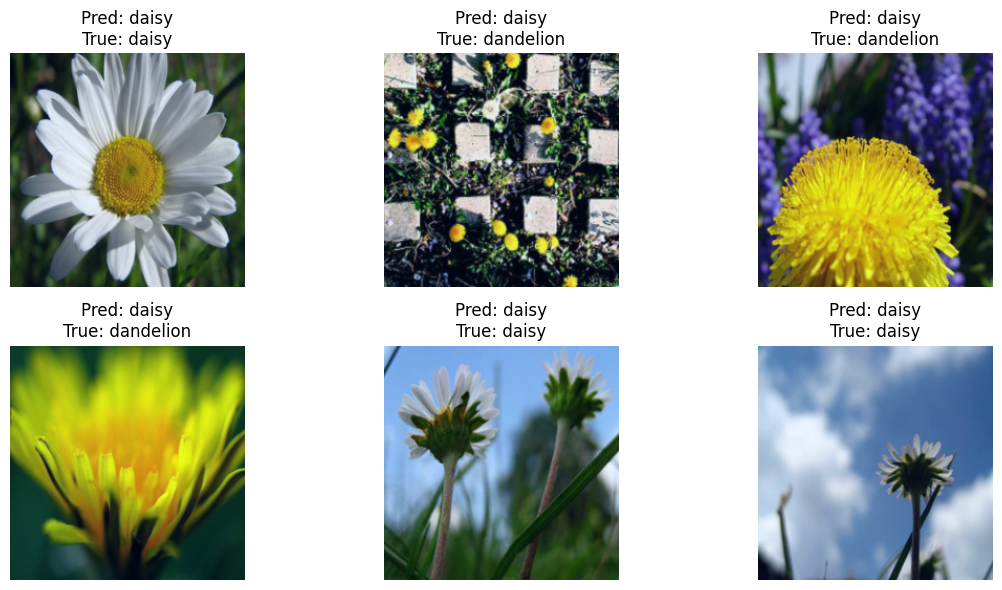

In [40]:
pretrained_vit.eval()
images, labels = next(iter(test_dataloader_pretrained))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = pretrained_vit(images)
    preds = outputs.argmax(dim=1)

num_images = len(images)

plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(2, (num_images + 1) // 2, i + 1)
    img = images[i].cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
